# Sentiment Analysis

## Import

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import html

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

from wordcloud import WordCloud
#import skimage.io as io
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from keras.layers import SpatialDropout1D
from keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print("Tensorflow Version",tf.__version__)

In [2]:
pd.set_option('display.max_colwidth', None)

## Lettura del dataset


In [3]:
df = pd.read_csv('./Dataset/training.1600000.processed.noemoticon.csv', encoding='latin',header=None)

# dato che il file CSV non ha un header, lo creiamo
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']

df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [4]:
# Dobbiamo addestrare il modello solamente sulla base del testo per poter classificare il sentiment quindi eliminiamo le altre colonne
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [5]:
# Decodifichiamo le etichette: 0->Negative, 4->Positive
lab_to_sentiment = {0: "Negative", 4: "Positive"}

def label_decoder(label):
    return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,Negative,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,Negative,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


Text(0.5, 1.0, 'Sentiment Data Distribution')

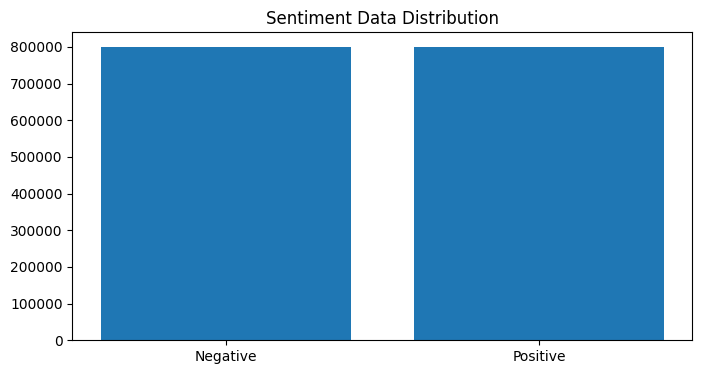

In [6]:
#Analizziamo le distribuzioni dei dati nel dataset
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title('Sentiment Data Distribution')

# Text Pre-Processing

In [7]:
# Funzione per rimuovere le codifiche HTML
def remove_html_entities(text):
    if isinstance(text, str):
        return html.unescape(text)
    return text

df['text'] = df['text'].apply(remove_html_entities)

In [8]:
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9']+"

In [9]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if stem:
      tokens.append(stemmer.stem(token))
    else:
      tokens.append(token)
  return " ".join(tokens)

In [10]:
df.text = df.text.apply(lambda x: preprocess(x))

# Word Cloud

In [ ]:
mask_happy = io.imread('/content/drive/MyDrive/PROGETTO CCS/smile.jpg')

In [ ]:
wordcloudhappy = WordCloud(colormap='prism', mask=mask_happy, background_color='black')
wordcloudhappy = wordcloudhappy.generate(" ".join(df[df.sentiment == 'Positive'].text))

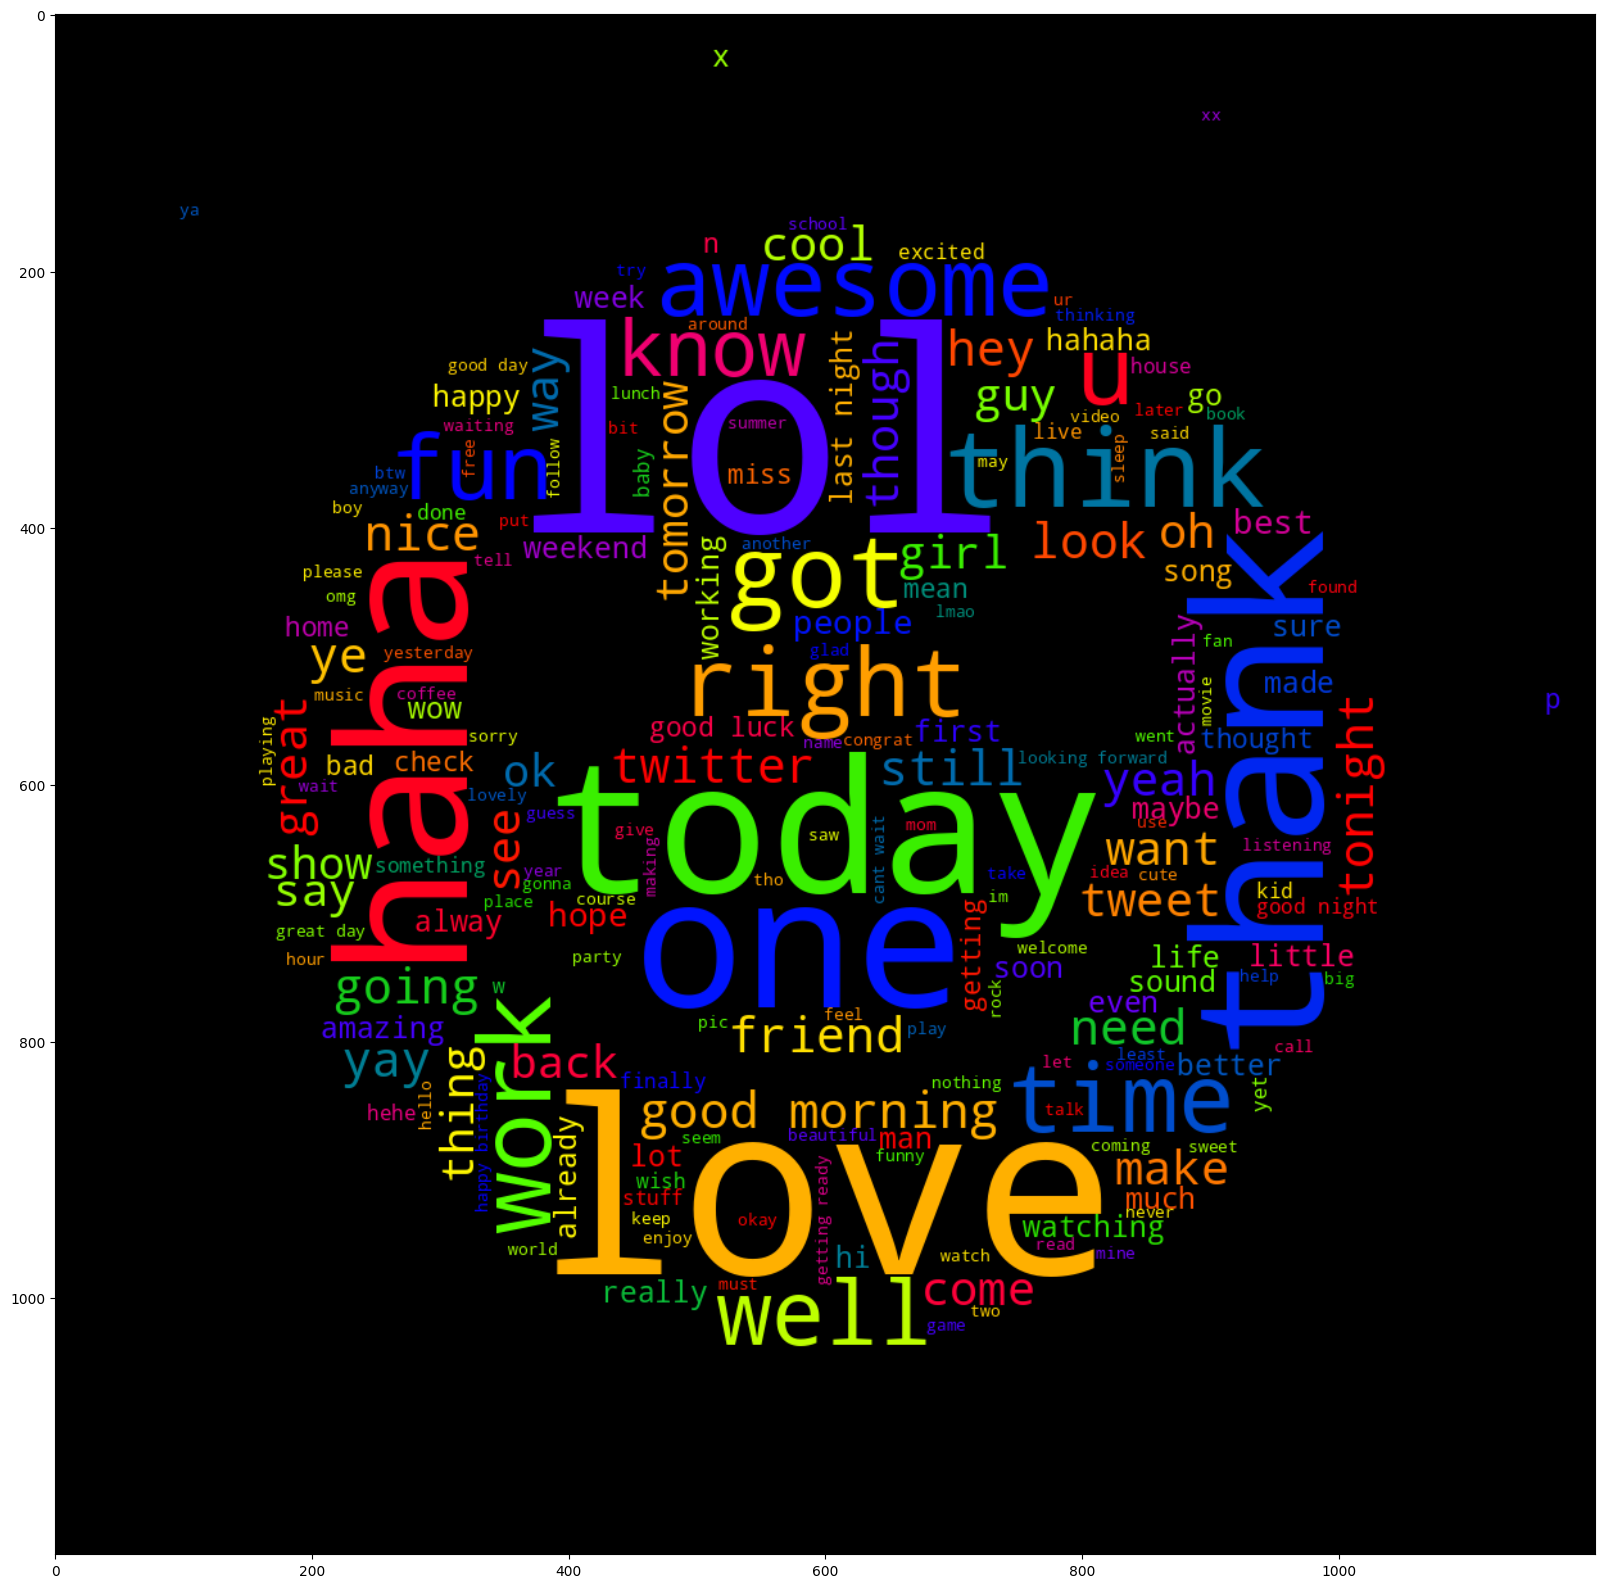

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow(wordcloudhappy, interpolation = 'bilinear')

In [ ]:
mask_sad = io.imread('/content/drive/MyDrive/PROGETTO CCS/sad.jpg')

In [ ]:
wordcloudsad = WordCloud(colormap='prism', mask=mask_sad, background_color='black')
wordcloudsad = wordcloudsad.generate(" ".join(df[df.sentiment == 'Negative'].text))

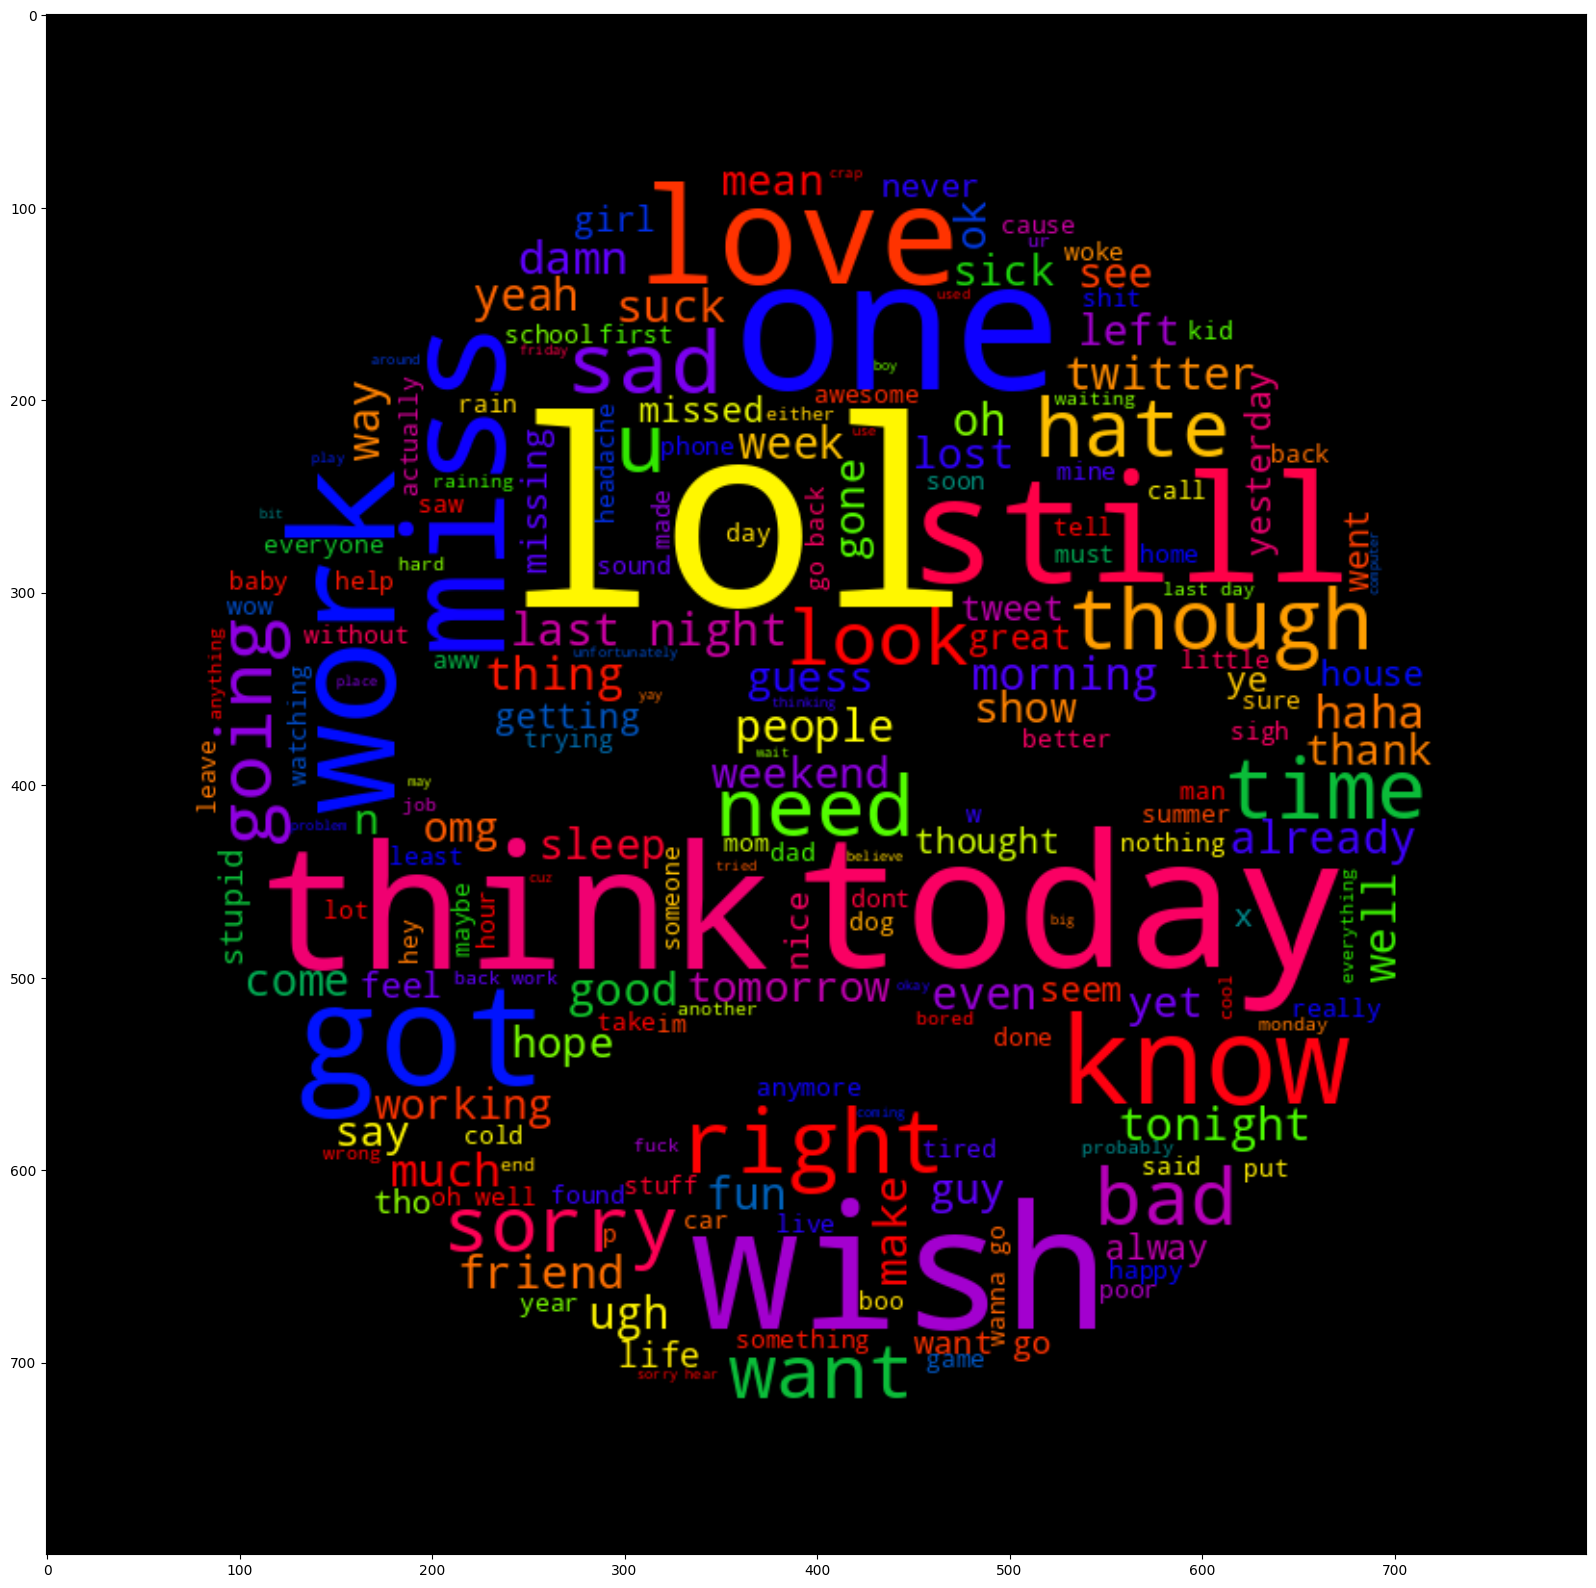

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow(wordcloudsad, interpolation = 'bilinear')

# Ricerca del commento con più parole

In [ ]:
def conta_parole(commento):
    parole = commento.split()
    return len(parole)


max_parole = 0
commento_max_parole = ""
indice_max_parole = -1

# Itera sui commenti del DataFrame con l'indice
for indice, commento in enumerate(df['text']):
    numero_parole = conta_parole(commento)
    if numero_parole > max_parole:
        max_parole = numero_parole
        commento_max_parole = commento
        indice_max_parole = indice

print("Il commento con il maggior numero di parole è:")
print(commento_max_parole)
print(f"Numero di parole: {max_parole}")
print(f"Indice del commento: {indice_max_parole}")


# Train - Test Split

In [12]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 50

train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set


print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [13]:
labels = train_data.sentiment.unique().tolist()
print(labels)

['Negative', 'Positive']


# Tokenization

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 309814


In [15]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)


x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 50)
Testing X Shape: (320000, 50)


# Label Encoding

In [16]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


# Train - Validation - Test Split

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Validation set


print("Train Data size:", len(x_train))
print("Validation Data size:", len(x_val))
print("y_train Data size:", len(y_train))
print("y_val Data size:", len(y_val))


Train Data size: 1024000
Validation Data size: 256000
y_train Data size: 1024000
y_val Data size: 256000


# Word Embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [18]:
GLOVE_EMB = './glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 40
MODEL_PATH = './Prova_best_model.hdf5'

In [19]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [20]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [21]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# Model Training - LSTM

In [22]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           92944200  
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 300)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 46, 64)            96064     
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               66048 

# Compile del modello e funzioni di callback

In [ ]:
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.00001,
                                     monitor = 'val_loss',
                                     patience = 4,
                                     min_delta = 0.01,
                                     verbose = 1)

SaveBestModel= ModelCheckpoint(
    MODEL_PATH,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="min",
    save_freq="epoch")

# Addestamento con dataset suddiviso in Train - Validation - Test

In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_val, y_val), callbacks=[reduce_lr, SaveBestModel])

# Plot delle curve di addestramento

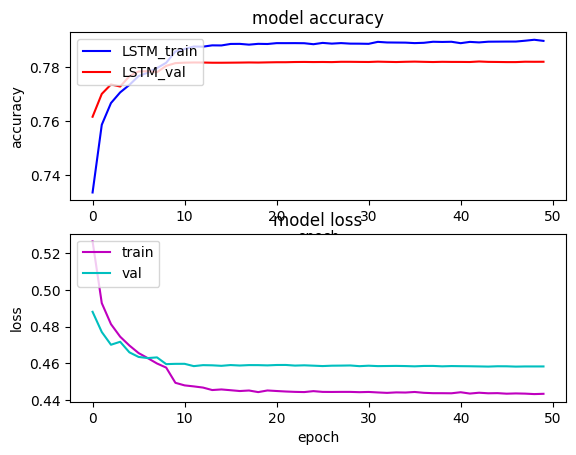

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

# Addestramento con dataset completo

In [ ]:
#train-test split
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 50

train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set


print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))


labels = train_data.sentiment.unique().tolist()
print(labels)

#Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)


x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

#label encoding
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

#Word embedding
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

#Model training
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])


# Funzioni di callback
reduce_lr = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.00001,
                                     monitor = 'val_loss',
                                     patience = 4,
                                     min_delta = 0.01,
                                     verbose = 1)

SaveBestModel= ModelCheckpoint(
    MODEL_PATH,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="min",
    save_freq="epoch")

#Caricamento dei pesi del modello
#model.load_weights(MODEL_PATH)

#train del modello su unione di train e val
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[reduce_lr, SaveBestModel])

In [41]:
# @title Caricamento pesi salvati
model.load_weights('./Prova_best_model.hdf5')

# Plot delle curve dell'addestramento con dataset completo

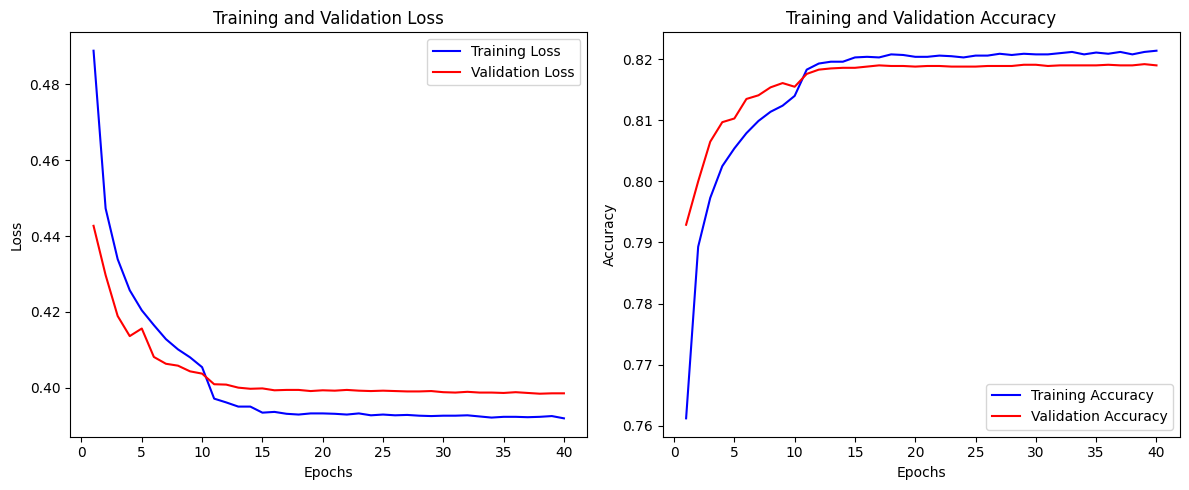

In [55]:
# Leggi i valori dai file di testo
def read_values(file_path):
    with open(file_path, 'r') as file:
        values = [float(line.strip()) for line in file]
    return values

# Percorsi ai file di testo
train_loss_path = './train_loss.txt'
val_loss_path = './val_loss.txt'
train_accuracy_path = './train_accuracy.txt'
val_accuracy_path = './val_accuracy.txt'

# Leggi i valori
train_loss = read_values(train_loss_path)
val_loss = read_values(val_loss_path)
train_accuracy = read_values(train_accuracy_path)
val_accuracy = read_values(val_accuracy_path)

# Epoche
epochs = range(1, 41)

# Plot delle loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot delle accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Mostra i plot
plt.tight_layout()
plt.show()


In [24]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 172s 5s/step


# Funzione di stampa della matrice di confusione

In [25]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)

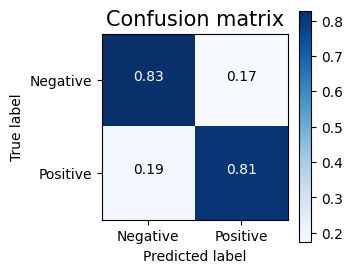

In [26]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [27]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.82      0.83      0.82    160542
    Positive       0.82      0.81      0.82    159458

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

